In [1]:
import sys
path = '/content/drive/MyDrive/3dminist/archive'
sys.path.append(path)
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/3dminist/archive']


In [2]:
import os
import random

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='2' #only show fatal and error

In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sn
import tensorflow as tf
from matplotlib.pyplot import cm
print(tf.__version__)
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import classification_report, confusion_matrix


2.9.2


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import OneHotEncoder
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import random

In [6]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, GlobalAveragePooling3D, Input,
                                     MaxPool3D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [7]:
with h5py.File("/content/drive/MyDrive/3dminist/archive/test_point_clouds.h5", "r") as points_dataset:
    digits = []
    for i in range(10):
        digit = (
            points_dataset[str(i)]['img'][:],
            points_dataset[str(i)]['points'][:],
            points_dataset[str(i)].attrs['label'], # num 7
        )
        digits.append(digit)

x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]

trace1 = go.Scatter3d(
    x=x_c,
    y=y_c,
    z=z_c,
    mode='markers',
    marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.7),
)

data = [trace1]
layout = go.Layout(
    height=600, width=600, title=f'Digit: {str(digits[0][2])} in 3D space'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)



Build Train and Validation Datasets
Before we move to implementing our 3D CNN model, we will split our dataset into train and validation sets. Our case differs from the usual image classification problem, where we have a 2D image. In our case, we have a 3D image. Therefore, our input shape instead of (height, width, channels) will be (width, height, depth, channels).

In [8]:
with h5py.File("/content/drive/MyDrive/3dminist/archive/full_dataset_vectors.h5", "r") as hf:    
    # Split the data into training/test features/targets
    x_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    x_test = hf["X_test"][:] 
    y_test = hf["y_test"][:]


# print(y_train.reshape(len(y_train),1)[:10])
# print(y_test.shape)
threshold, upper, lower = 0.2, 1, 0
x_train = np.where(x_train>threshold, upper, lower)
x_test = np.where(x_test>threshold, upper, lower)



x_train = x_train.reshape(x_train.shape[0], 1, 16,16,16)
x_test = x_test.reshape(x_test.shape[0], 1, 16,16,16)

onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_onehot = onehot_encoder.transform(y_test.reshape(len(y_test), 1))

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("y_train_onehot", y_train_onehot.shape)

print("x_test", x_test.shape)
print("y_test", y_test.shape)
print("y_test_onehot", y_test_onehot.shape)

x_train (10000, 1, 16, 16, 16)
y_train (10000,)
y_train_onehot (10000, 10)
x_test (2000, 1, 16, 16, 16)
y_test (2000,)
y_test_onehot (2000, 10)


In [9]:
model = Sequential([
    layers.Conv3D(8, (3,3,3), activation='relu', padding='same', input_shape=(1, 16,16,16)),
    layers.Conv3D(16, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((2,2,2), padding='same'),
    
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((2,2,2), padding='same'),
    
    layers.Conv3D(16, (3,3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling3D(),
    layers.Flatten(),
    
    layers.Dense(units=1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=10, activation='softmax'),
])

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 1, 16, 16, 8)      3464      
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 16, 16)     3472      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 8, 8, 16)      0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 8, 8, 32)       13856     
                                                                 
 conv3d_3 (Conv3D)           (None, 1, 8, 8, 64)       55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 4, 4, 64)      0         
 3D)                                                    

In [12]:
history = model.fit(x=x_train, y=y_train_onehot, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
63/63 [==============================] - 25s 385ms/step - loss: 1.9761 - acc: 0.2756 - val_loss: 2.5045 - val_acc: 0.1520
Epoch 2/30
63/63 [==============================] - 24s 379ms/step - loss: 1.4560 - acc: 0.4910 - val_loss: 2.0520 - val_acc: 0.2730
Epoch 3/30
63/63 [==============================] - 24s 381ms/step - loss: 1.2267 - acc: 0.5659 - val_loss: 1.7990 - val_acc: 0.3685
Epoch 4/30
63/63 [==============================] - 24s 382ms/step - loss: 1.1159 - acc: 0.6022 - val_loss: 1.3905 - val_acc: 0.5465
Epoch 5/30
63/63 [==============================] - 24s 383ms/step - loss: 1.0394 - acc: 0.6286 - val_loss: 1.4503 - val_acc: 0.5015
Epoch 6/30
63/63 [==============================] - 24s 387ms/step - loss: 0.9938 - acc: 0.6428 - val_loss: 1.1478 - val_acc: 0.6205
Epoch 7/30
63/63 [==============================] - 26s 411ms/step - loss: 0.9453 - acc: 0.6606 - val_loss: 1.2033 - val_acc: 0.5760
Epoch 8/30
63/63 [==============================] - 26s 408ms/step - 

In [13]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [14]:
model.evaluate(x=x_test, y=y_test_onehot)

63/63 [==============================] - 2s 25ms/step - loss: 1.2908 - acc: 0.6745


[1.2908297777175903, 0.6744999885559082]

{}


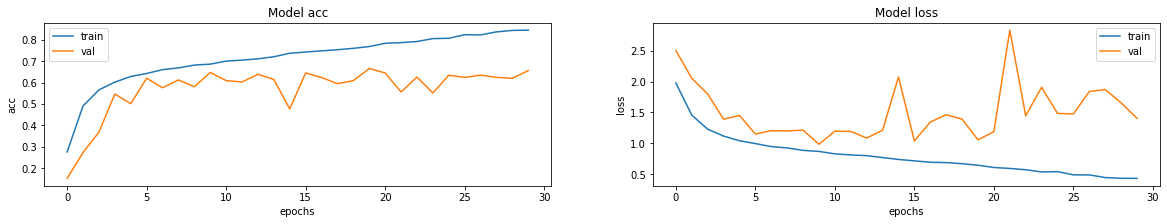

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
print(y_test_onehot.shape)
y_prediction = model.predict(x_test)

print(classification_report(y_test_onehot.argmax(axis=1), y_prediction.argmax(axis=1), digits=3))


(2000, 10)
63/63 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0      0.837     0.876     0.856       170
           1      0.953     0.976     0.965       252
           2      0.750     0.543     0.630       232
           3      0.527     0.598     0.560       214
           4      0.928     0.468     0.622       220
           5      0.462     0.592     0.519       174
           6      0.790     0.540     0.642       174
           7      0.778     0.657     0.712       198
           8      0.444     0.843     0.581       178
           9      0.615     0.638     0.627       188

    accuracy                          0.674      2000
   macro avg      0.708     0.673     0.671      2000
weighted avg      0.720     0.674     0.678      2000



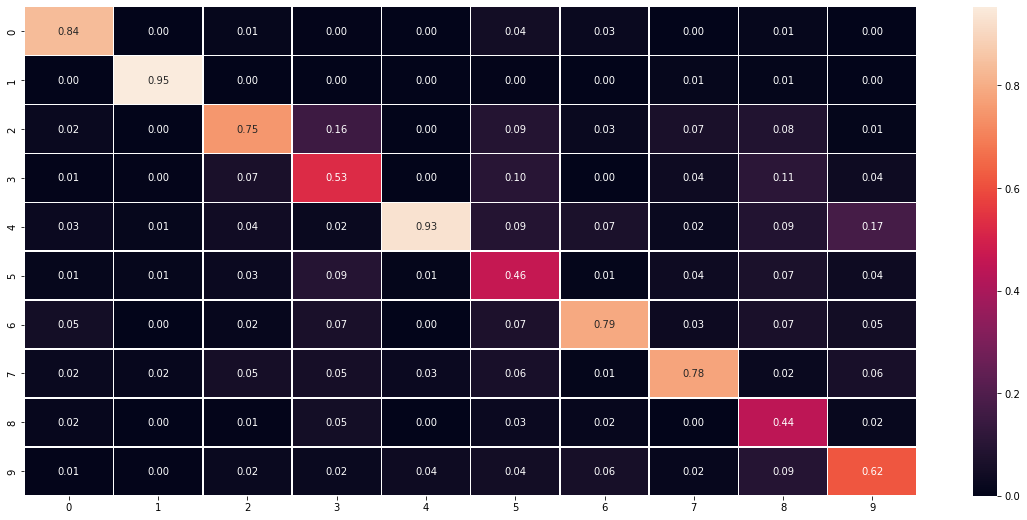

In [17]:
confusion_matrix_result = confusion_matrix(y_test_onehot.argmax(axis=1), y_prediction.argmax(axis=1) , normalize='pred')
df_cm = pd.DataFrame(confusion_matrix_result, index=range(10), columns=range(10))
plt.figure(figsize=(20, 9))
sn.heatmap(df_cm, annot=True, linewidths=0.5, fmt=".2f")